In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.optim as  optim
from torchvision import datasets
from torch.utils.data import DataLoader

from torch.autograd import Variable

In [2]:
from torch.utils.data import Dataset

In [3]:
import pandas as pd

In [4]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
!unzip celeba.zip -d data_faces
!rm -r celeba.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: data_faces/img_align_celeba/197600.jpg  
 extracting: data_faces/img_align_celeba/197601.jpg  
 extracting: data_faces/img_align_celeba/197602.jpg  
 extracting: data_faces/img_align_celeba/197603.jpg  
 extracting: data_faces/img_align_celeba/197604.jpg  
 extracting: data_faces/img_align_celeba/197605.jpg  
 extracting: data_faces/img_align_celeba/197606.jpg  
 extracting: data_faces/img_align_celeba/197607.jpg  
 extracting: data_faces/img_align_celeba/197608.jpg  
 extracting: data_faces/img_align_celeba/197609.jpg  
 extracting: data_faces/img_align_celeba/197610.jpg  
 extracting: data_faces/img_align_celeba/197611.jpg  
 extracting: data_faces/img_align_celeba/197612.jpg  
 extracting: data_faces/img_align_celeba/197613.jpg  
 extracting: data_faces/img_align_celeba/197614.jpg  
 extracting: data_faces/img_align_celeba/197615.jpg  
 extracting: data_faces/img_align_celeba/197616.jpg  
 ext

In [5]:
!gdown --id 1s1ILu5QLJbV-rBGVkWxIzKz6G1ExjnJV
!unzip list_attr_celeba.csv.zip -d data_faces
!rm -r list_attr_celeba.csv.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1s1ILu5QLJbV-rBGVkWxIzKz6G1ExjnJV
To: /content/list_attr_celeba.csv.zip
100% 2.12M/2.12M [00:00<00:00, 177MB/s]
Archive:  list_attr_celeba.csv.zip
  inflating: data_faces/list_attr_celeba.csv  


In [6]:
class CelebADataset(Dataset):
    def __init__(self, data, labels,classes, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.classes = classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(os.path.join('data_faces','img_align_celeba',self.data[idx])).convert('RGB')
        label = torch.Tensor(self.labels[idx,[39,20,22,2,31,15]].astype('uint8'))
        if self.transform:
            img = self.transform(img)
        sample = {'images': img, 'labels': label}
        return sample

In [7]:
import torchvision.utils as vutils
def display_grid(images,
                 nrow=8,
                 figsize=(12,12)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(
        np.transpose(
            vutils.make_grid(images, nrow=nrow, padding=2, normalize=True).cpu(),(1,2,0)
        )
    )
    plt.axis('off')


In [8]:
#list_attr_celeba.csv: Attribute labels for each image.
#There are 40 attributes. "1" represents positive while "-1" represents negative
df = pd.read_csv("data_faces/list_attr_celeba.csv")

In [9]:
transform = transforms.Compose(
    [transforms.Resize(size=(128,128), interpolation=Image.BICUBIC),
     transforms.ToTensor()])

In [10]:
data, labels=df.values[:,0],(df.values[:,1:]+1)//2
classes=df.columns[1:]

In [11]:
celeba_data = CelebADataset(data, labels,classes,transform)
celeba_loader = DataLoader(celeba_data,batch_size=64,shuffle=True)

In [12]:
class VAE(nn.Module):
    def __init__(self, image_size=128, latent_dim=512):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.Embeddings = nn.Embedding(2,10)
        # Define the parameters for mean and variance
        self.fc_mu = nn.Linear(256 * (image_size // 16) * (image_size // 16), latent_dim)
        self.fc_logvar = nn.Linear(256 * (image_size // 16) * (image_size // 16), latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim+10*6, 256 * (image_size // 16) * (image_size // 16))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        self.image_size=image_size

    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, (self.image_size // 16), (self.image_size // 16))
        x = self.decoder(x)
        return x

    def forward(self, x,labels):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        B,_=z.shape
        z_labels=self.Embeddings(labels).reshape(B,-1)
        z=torch.cat([z,z_labels],1)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, logvar

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
#Downloading pretrained model weights.
!gdown --id 1mwANqzkhTSB64E43aj-31pVYcJr4wrBw

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1mwANqzkhTSB64E43aj-31pVYcJr4wrBw
From (redirected): https://drive.google.com/uc?id=1mwANqzkhTSB64E43aj-31pVYcJr4wrBw&confirm=t&uuid=8f0f6fc0-96f6-4f4a-aa55-f80263004e93
To: /content/celeba_cvae.pth
100% 110M/110M [00:01<00:00, 55.9MB/s]


In [15]:
# Initialize VAE model
model = VAE().to(device)
model.load_state_dict(torch.load('celeba_cvae.pth'))

<All keys matched successfully>

In [16]:
data= next(iter(celeba_loader))
imgs, labels= data['images'].float().to(device),data['labels'].long().to(device)


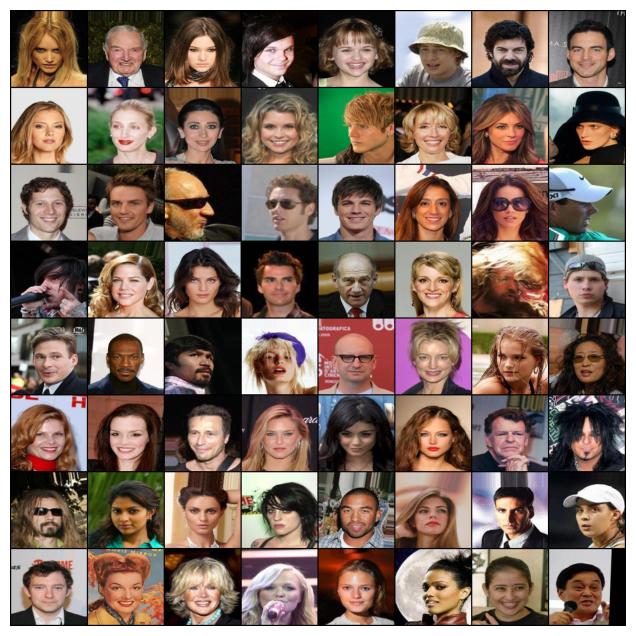

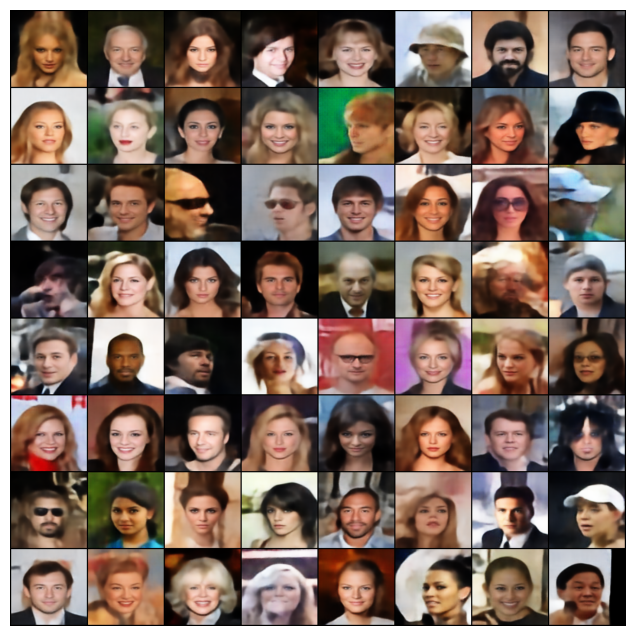

In [17]:
#Visualizing some reconstructions
with torch.no_grad():
    reconstructions,_,_ = model(imgs,labels)
    reconstructions=reconstructions.detach().cpu().clip(0,1)
display_grid(imgs.detach().cpu(), figsize=(8,8))
plt.show()
display_grid(reconstructions, figsize=(8,8))
plt.show()

In [18]:
#Selecting the image attributes to be modified
att_names=classes[[39,20,22,2,31,15]]
att_names

Index(['Young', 'Male', 'Mustache', 'Attractive', 'Smiling', 'Eyeglasses'], dtype='object')

Text(0.5, 1.0, 'Male 0 ')

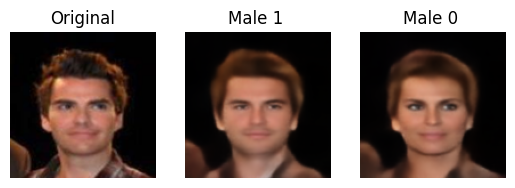

In [50]:
#Select a random image from the test set
sample_idx=np.random.choice(len(imgs))


with torch.no_grad():
    reconstructions,_,_ = model(imgs[[sample_idx]],labels[[sample_idx]])
    reconstructions=reconstructions.detach().cpu().clip(0,1)

#Select an attribute to be modified from 0 to 5. ['Young', 'Male', 'Mustache', 'Attractive', 'Smiling', 'Eyeglasses']
att_idx=1
#Modifying the image attributes
new_labels=labels[[sample_idx]]
new_labels[:,att_idx]=1-new_labels[:,att_idx]
with torch.no_grad():
    reconstructions2,_,_ = model(imgs[[sample_idx]],new_labels)
    reconstructions2=reconstructions2.detach().cpu().clip(0,1)


plt.subplot(131)
plt.imshow(imgs[[sample_idx]].permute(0,2,3,1).cpu().numpy()[0])
plt.axis('off')
plt.title('Original')
plt.subplot(132)
plt.imshow(reconstructions.permute(0,2,3,1).numpy()[0])
plt.axis('off')
plt.title(att_names[att_idx]+' %d '%(labels[sample_idx,att_idx]))
plt.subplot(133)
plt.imshow(reconstructions2.permute(0,2,3,1).numpy()[0])
plt.axis('off')
plt.title(att_names[att_idx]+' %d '%(1-labels[sample_idx,att_idx]))
